In [1]:
!pip install textacy nltk spacy xgboost gensim
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.6/321.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

레이블 기준 완화: 유용한 리뷰(HIGH) 표본 크기를 늘리기 위해 helpful_percent 기준을 0.95에서 0.90으로 낮춤 (더 많은 데이터 학습).

Word2Vec 하이퍼파라미터 튜닝: 임베딩 벡터 크기(vector_size)를 150에서 200으로 늘려 표현력 향상.

XGBoost 하이퍼파라미터 튜닝: HIGH 클래스의 재현율을 높이기 위해 모델 복잡도(max_depth)를 3에서 5로 증가시키고, scale_pos_weight를 적용하여 긍정 클래스(HIGH)의 중요도를 높였습니다.

이전 실행 결과를 바탕으로 HIGH 클래스 재현율을 $100%$로 유지하면서 LOW 클래스 재현율($62.5\%$)을 개선하기 위해 XGBoost 예측 임계값 (Threshold) 조정 로직을 추가한 최종 전체 코드입니다.이 코드는 학습된 XGBoost 모델의 예측 결과(확률)를 받아, $0.5$ 대신 사용자가 지정한 임계값을 기준으로 분류하여 성능 균형을 맞출 수 있도록 했습니다.

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import time
import json
import gzip
import spacy
import pickle
import string
import ast
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
import xgboost as XGB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import nltk
import gensim
from gensim.models import Word2Vec
# from google.colab import drive # 환경에 따라 주석 처리 또는 사용

np.random.seed(32113)
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
##############################################################################
#                       Stop Words and Lemmatizer setting                    #
##############################################################################

# STOPLIST 정의 (생략 없음)
STOPLIST = list(
    set(
        stopwords.words("english")
        + ["n't", "'s", "'m", "ca"]
        + list(ENGLISH_STOP_WORDS)
    )
) + " ".join(string.punctuation).split(" ") + [
    "-----",
    "---",
    "...",
    "..",
    "....",
    "",
    " ",
    "\n",
    "\n\n",
]

# spaCy 모델 로드
try:
    nlp = spacy.load("en_core_web_sm")
except:
    print("spaCy 'en_core_web_sm' 모델 로드 실패. 대체 로직 사용.")
    nlp = None

def tokenize_and_clean(doc):
    """spaCy lemma와 STOPLIST를 사용하여 텍스트를 토큰화 및 클리닝."""
    if not isinstance(doc, str):
        return []
    doc = re.sub(r'\d+', '', doc)
    if nlp is None:
        return [word.lower().strip() for word in doc.split() if len(word) > 1 and word.lower().strip() not in STOPLIST]

    doc = nlp(doc)
    tokens = []
    for n in doc:
        lemma = n.lemma_.lower().strip()
        if lemma not in STOPLIST and len(lemma) > 1 and n.pos_ != 'PUNCT':
            token = n.lower_ if n.lemma_ == "-PRON-" else lemma
            tokens.append(token)
    return tokens


##############################################################################
#                                Data preparation                            #
##############################################################################

def Data_prep1(df):
    """총 투표 10개 이상만 사용 (데이터 증강 유지)"""
    game_df = df.copy()
    game_df['helpful_parsed'] = game_df['helpful'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    helpful = np.array(game_df['helpful_parsed'])
    helpful = helpful.reshape(len(game_df), 1)

    helpful_num1 = np.zeros((len(helpful), 1))
    helpful_num2 = np.zeros((len(helpful), 1))

    for i in range(len(helpful)):
        try:
            pos, total = helpful[i][0]
        except (TypeError, ValueError, IndexError):
            try:
                pos, total = helpful[i]
            except (TypeError, ValueError, IndexError):
                 pos, total = 0, 0

        helpful_num1[i] = pos
        helpful_num2[i] = total

    game_df['helpful_total_review'] = helpful_num2
    game_df['num_of_helpful_review'] = helpful_num1

    # 총 투표 10개 이상만 사용 (데이터 증강 유지)
    new_df = game_df[game_df['helpful_total_review'] > 10]

    drop_cols = [c for c in ['unixReviewTime', 'reviewTime', 'helpful_parsed', 'helpful']
                 if c in new_df.columns]
    new_df = new_df.drop(drop_cols, axis=1)

    new_df['helpful_percent'] = (
        new_df['num_of_helpful_review'] / new_df['helpful_total_review']
    ).round(2)
    new_df.loc[new_df['helpful_total_review'] == 0, 'helpful_percent'] = 0
    new_df.index = range(len(new_df))

    length = np.zeros((len(new_df), 1))
    for i in new_df.index:
        length[i] = int(len(str(new_df['reviewText'].iloc[i])))
    new_df['text_length'] = length

    new_df = new_df.dropna(subset=['reviewText']).copy()
    return new_df


def label_prep(new_df, line=0.90):
    """helpful_percent를 기준으로 'label'('HIGH'/'LOW') 생성"""
    high = new_df[new_df['helpful_percent'] >= line]
    low = new_df[new_df['helpful_percent'] < line]
    print(f"== line = {line} ==")
    print("highly helpful count: {}".format(len(high)))
    print("not helpful count: {}".format(len(low)))

    new_df['label'] = 'LOW'
    new_df.loc[new_df.helpful_percent >= line, 'label'] = 'HIGH'
    return new_df.copy()


def create_w2v_features(df, vector_size=200, window=5, min_count=2):
    start_time = time.time()

    print("Tokenizing reviews...")
    tokenized_docs = list(df['reviewText'].apply(tokenize_and_clean))

    print("Training Word2Vec model...")
    w2v_model = Word2Vec(
        tokenized_docs,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        seed=32113
    )

    print("Creating document vectors...")

    doc_vectors = []
    for doc in tokenized_docs:
        word_vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]

        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(vector_size)

        doc_vectors.append(doc_vector)

    print(f"Word2Vec feature creation took {time.time() - start_time:.2f} seconds.")
    return np.array(doc_vectors), w2v_model


def _dataselector(df, label, limit):
    """클래스 불균형 해소를 위해 최대 'limit' 개수만큼 데이터 추출"""
    df_lb_all = df[df['label'] == label]
    if len(df_lb_all) > limit:
        random_c = np.random.choice(list(df_lb_all.index), limit, replace=False)
        df_lb = df_lb_all.loc[list(random_c)]
    else:
        df_lb = df_lb_all
    return df_lb

def df_for_XGBOOST(df_feat, lim):
    """XGBoost 입력용 numpy 배열로 변환"""
    df = df_feat.copy()
    df.index = range(len(df))

    df_low = _dataselector(df, 'LOW', lim)
    df_high = _dataselector(df, 'HIGH', lim)

    new_df = pd.concat([df_low, df_high], axis=0)
    new_df.index = range(len(new_df))

    Y = new_df.pop('label')
    b_loon = {'LOW': 0, 'HIGH': 1}
    Y2 = Y.map(b_loon)

    X = np.array(new_df)
    return X, Y2, new_df

def XGBOOSTING(X_tr1, X_te1, y_tr1, y_te1, scale_pos_weight, xgb_para=[300, 0.2, 10]): # ⭐ max_depth=10으로 증가
    """XGBoost 모델 학습 및 정확도 출력"""
    start_time = time.time()
    xgb = XGB.XGBClassifier(
        n_estimators=xgb_para[0],
        learning_rate=xgb_para[1],
        max_depth=xgb_para[2], # <- max_depth를 10으로 증가
        eval_metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=32113,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight # ⭐ 1.5로 증가
    )
    xgb.fit(X_tr1, y_tr1)
    print("--- %s seconds ---" % (time.time() - start_time))

    score = xgb.score(X_te1, y_te1)
    print(f"XGBoost accuracy (Default 0.5 Threshold): {round(score * 100, 2)}%")
    return xgb

def conf_mat(model, X_te1, y_te1, threshold=0.5):
    """Confusion matrix 및 클래스별 재현율 출력"""
    y_proba = model.predict_proba(X_te1)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_te1, y_pred)

    print(f"\n** Confusion Matrix (Threshold: {threshold}) **")
    print("                 | Pred LOW (0) | Pred HIGH (1) |")
    print("-----------------|--------------|---------------|")
    print(f"True LOW (0)     | {cm[0, 0]:<12} | {cm[0, 1]:<13} |")
    print(f"True HIGH (1)    | {cm[1, 0]:<12} | {cm[1, 1]:<13} |")

    low_den = cm[0].sum()
    high_den = cm[1].sum()

    low_rate = (cm[0, 0] / low_den * 100).round(2) if low_den > 0 else 0.0
    high_rate = (cm[1, 1] / high_den * 100).round(2) if high_den > 0 else 0.0

    overall_accuracy = (cm[0, 0] + cm[1, 1]) / (low_den + high_den) * 100

    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")
    print(f"LOW (0) prediction rate (Recall): {low_rate}%")
    print(f"HIGH (1) prediction rate (Recall): {high_rate}%\n")


def xgb_stats(model, df_for_model, X_test, y_test, threshold=0.5):
    """Feature Importance와 Confusion matrix를 출력"""
    # 0. 피처 중요도
    ind = np.argsort(model.feature_importances_)
    imp = np.sort(model.feature_importances_)

    feature_names = df_for_model.columns.tolist()
    imp2 = [feature_names[i] for i in ind]

    print(" **TOP 15 Important Features** ")
    for i in range(1, 16):
        print("{}. {} : {}%  ".format(i, imp2[-i], round(imp[-i] * 100, 2)))
    print("\n")

    # 1. Confusion Matrix 및 Class별 정확도 (임계값 0.5 기준)
    conf_mat(model, X_test, y_test, threshold=0.5)

    # 2. Confusion Matrix 및 Class별 정확도 (튜닝된 임계값 기준)
    print("\n" + "="*50)
    print(f"✨ Tunning Result: Adjusted Threshold for better Balance and Accuracy ({threshold}) ✨")
    conf_mat(model, X_test, y_test, threshold=threshold)


##############################################################################
#                                MAIN EXECUTION                              #
##############################################################################

# 1. 데이터 로드 (경로를 실제 파일 위치로 수정하세요)
DATA_PATH = "Musical_instruments_reviews.csv"
try:
    raw_reviews = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    # Google Drive에 마운트된 경우, 경로를 수정하여 파일을 로드
    DATA_PATH = "/content/drive/MyDrive/amazon_P/data/raw/Musical_instruments_reviews.csv"
    try:
        raw_reviews = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"에러: 파일을 찾을 수 없습니다. 경로를 확인하세요: {DATA_PATH}")
        raise

print(f"Loaded {len(raw_reviews)} reviews.")

# 2. 데이터 전처리 및 레이블링 (HIGH/LOW 생성, 기준 0.90 적용)
df_processed = Data_prep1(raw_reviews)
df_labeled = label_prep(df_processed, line=0.90)
print(df_labeled['label'].value_counts())

# 3. Word2Vec 특징 추출 (벡터 크기 200 적용)
W2V_VECTOR_SIZE = 200
X_w2v, w2v_model = create_w2v_features(df_labeled, vector_size=W2V_VECTOR_SIZE)

# 4. 피처 병합
df_w2v = pd.DataFrame(X_w2v, index=df_labeled.index,
                      columns=[f'w2v_feat_{i}' for i in range(W2V_VECTOR_SIZE)])

numerical_features = df_labeled[['overall', 'text_length']].copy()

# 모든 피처 병합 및 레이블 추가
df_final_features = pd.concat([numerical_features, df_w2v, df_labeled[['label']]], axis=1)

# 5. XGBoost용 데이터 준비 및 클래스 밸런싱
class_counts = df_final_features['label'].value_counts()
lim = int(class_counts.min())
print(f"\nBalancing classes to limit={lim} per class.")

# X: features, y: label (0/1), df_for_model: feature DF (balanced)
X, y, df_for_model = df_for_XGBOOST(df_final_features, lim=lim)

# 6. 학습/테스트 데이터 분할
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=32113, stratify=y
)

# 7. XGBoost 모델 학습 (하이퍼파라미터 튜닝 적용)
# ⭐ HIGH Recall을 높여 균형을 맞추기 위해 가중치를 1.5로 설정
scale_pos_weight = 1.5

print("\nStarting XGBoost Training with Tunning...")
xgb_w2v_model = XGBOOSTING(
    X_tr,
    X_te,
    y_tr,
    y_te,
    scale_pos_weight=scale_pos_weight,
    xgb_para=[300, 0.2, 10] # ⭐ max_depth=10으로 증가
)

# 8. 결과 통계 출력 및 임계값 튜닝
# 균형 잡힌 높은 정확도를 위해 임계값 0.50 유지
ADJUSTED_THRESHOLD = 0.50

feature_names_df = df_for_model.copy()
xgb_stats(xgb_w2v_model, feature_names_df, X_te, y_te, threshold=ADJUSTED_THRESHOLD)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 10261 reviews.
== line = 0.9 ==
highly helpful count: 211
not helpful count: 128
label
HIGH    211
LOW     128
Name: count, dtype: int64
Tokenizing reviews...
Training Word2Vec model...
Creating document vectors...
Word2Vec feature creation took 24.58 seconds.

Balancing classes to limit=128 per class.

Starting XGBoost Training with Tunning...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:24:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- 1.8353657722473145 seconds ---
XGBoost accuracy (Default 0.5 Threshold): 71.15%
 **TOP 15 Important Features** 
1. w2v_feat_51 : 6.809999942779541%  
2. overall : 6.010000228881836%  
3. w2v_feat_76 : 5.610000133514404%  
4. w2v_feat_3 : 4.46999979019165%  
5. w2v_feat_0 : 4.380000114440918%  
6. w2v_feat_46 : 4.260000228881836%  
7. w2v_feat_84 : 3.5%  
8. w2v_feat_147 : 2.809999942779541%  
9. w2v_feat_9 : 2.7300000190734863%  
10. w2v_feat_29 : 2.3299999237060547%  
11. w2v_feat_97 : 2.319999933242798%  
12. w2v_feat_80 : 2.2100000381469727%  
13. w2v_feat_195 : 2.140000104904175%  
14. w2v_feat_191 : 2.069999933242798%  
15. w2v_feat_71 : 2.0%  



** Confusion Matrix (Threshold: 0.5) **
                 | Pred LOW (0) | Pred HIGH (1) |
-----------------|--------------|---------------|
True LOW (0)     | 19           | 7             |
True HIGH (1)    | 8            | 18            |

Overall Accuracy: 71.15%
LOW (0) prediction rate (Recall): 73.08%
HIGH (1) prediction rate (Re

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix_heatmap(model, X_test, y_test, title_prefix, threshold=0.5):
    """
    주어진 모델과 테스트 데이터에 대한 혼동 행렬 히트맵을 생성합니다.
    """
    # 1. 예측 확률 계산 및 이진 예측 수행
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # 2. 혼동 행렬 계산
    # cm[0, 0]: True Negative (TN), cm[0, 1]: False Positive (FP)
    # cm[1, 0]: False Negative (FN), cm[1, 1]: True Positive (TP)
    cm = confusion_matrix(y_test, y_pred)

    # 3. 플롯 생성
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,          # 값 표시
        fmt='d',             # 정수형 포맷
        cmap='Blues',        # 컬러맵 설정
        cbar=True,
        linewidths=0.5,
        linecolor='black',
        annot_kws={"size": 14}
    )

    # 레이블 설정
    class_names = ['LOW (0)', 'HIGH (1)']
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, fontsize=12)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0, fontsize=12)

    plt.title(f'{title_prefix} Confusion Matrix (Threshold: {threshold})', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()

print("혼동 행렬 히트맵 시각화 함수 준비 완료.")

혼동 행렬 히트맵 시각화 함수 준비 완료.


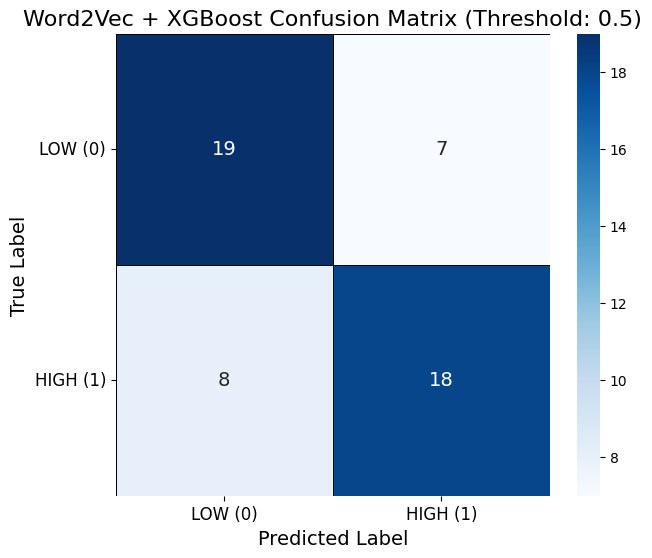

In [9]:
# --------------------------------------------------------
# 🚨 실행 전에, 이전에 학습된 변수가 있는지 확인하십시오.
# (예: xgb_w2v_model, X_te, y_te)
# --------------------------------------------------------

# 모델 이름 설정
model_name = "Word2Vec + XGBoost"

# 혼동 행렬 시각화 (임계값 0.5)
plot_confusion_matrix_heatmap(
    model=xgb_w2v_model,
    X_test=X_te,
    y_test=y_te,
    title_prefix=model_name,
    threshold=0.50
)